# Implementing Kinematics of a four-legged Robot 

Goal of this Document is to implement a calculation-logic which returns all the twelve angles (4 Legs x 3 Servos) when Body-Pose and Positions for all four feet in Global-Space are given.

The described Robot has four Legs, each one has three movable Parts (3DOF). 

## Why this custom solution?

There are plenty of Kinematics/IK-Solutions out there. There are three major reasons for this custom implementation:

- this Model will be Part of a guided RL-Network on a physical Robot running on the NVIDIA Jetson and it has to be as small and efficient as it can be. Maybe i will even port it to C when it's finally working.
- it IS just simple School-Math and we want to build a self-learning Robot, so we should be able to solve this!  So take a Coffee or two and focus on Pythagoras, atan2 and all the great things math gave us.

## Setup our 3D-Ouput

To verify all the calculations happening here, it is helpful to have some kind of visual output. 
In this document Matplotlib is used. 

In [309]:
from mpl_toolkits import mplot3d
import numpy as np
from math import *
import matplotlib.pyplot as plt

def setupView(limit):
    ax = plt.axes(projection="3d")
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_zlim(-limit, limit)
    ax.set_xlabel("X")
    ax.set_ylabel("Z")
    ax.set_zlabel("Y")
    return ax

## Inverse Kinematics of the Leg

We start with solving the Leg's Inverse Kinematics and calculate (theta1,theta2,theta3) - our output-angles - for a given Foot-Position (x,y,z) in Leg-Space. The Leg's Origin - the shoulder - is at (0,0,0). l1,l2,l3 and l4 are the length of the Leg's Segments.

<IPython.core.display.Javascript object>


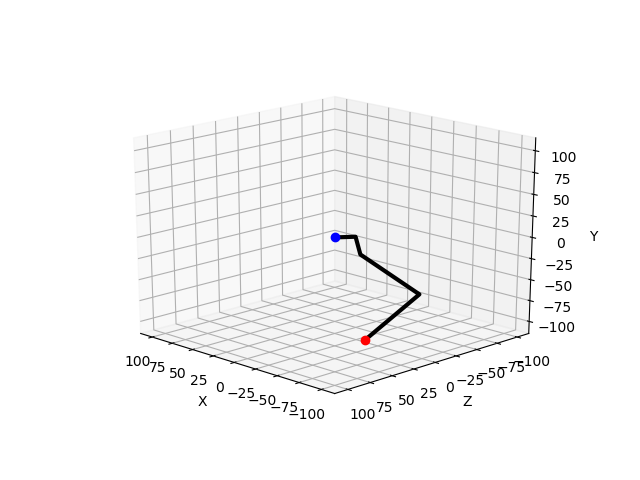

OK


In [310]:
%matplotlib notebook

setupView(110).view_init(elev=20., azim=135)

l1=25
l2=20
l3=80
l4=80

x=-55
y=-100
z=20

def legIK(x,y,z):
    
    """
    x/y/z=Position of the Foot in Leg-Space
    
    F=Length of shoulder-point to target-point on x/y only
    G=length we need to reach to the point on x/y
    H=3-Dimensional length we need to reach
    """

    F=sqrt(x**2+y**2-l1**2)
    G=F-l2  
    H=sqrt(G**2+z**2)

    theta1=-atan2(y,x)-atan2(F,-l1)
    
    D=(H**2-l3**2-l4**2)/(2*l3*l4)
    theta3=acos(D) 
    
    theta2=atan2(z,G)-atan2(l4*sin(theta3),l3+l4*cos(theta3))

    return(theta1,theta2,theta3)

def calcLegPoints(angles):
    
    (theta1,theta2,theta3)=angles
    theta23=theta2+theta3

    T0=np.array([0,0,0,1])
    T1=T0+np.array([-l1*cos(theta1),l1*sin(theta1),0,0])
    T2=T1+np.array([-l2*sin(theta1),-l2*cos(theta1),0,0])
    T3=T2+np.array([-l3*sin(theta1)*cos(theta2),-l3*cos(theta1)*cos(theta2),l3*sin(theta2),0])
    T4=T3+np.array([-l4*sin(theta1)*cos(theta23),-l4*cos(theta1)*cos(theta23),l4*sin(theta23),0])
        
    return np.array([T0,T1,T2,T3,T4])

def drawLegPoints(p):

    plt.plot([p[0][0],p[1][0],p[2][0],p[3][0],p[4][0]], 
             [p[0][2],p[1][2],p[2][2],p[3][2],p[4][2]],
             [p[0][1],p[1][1],p[2][1],p[3][1],p[4][1]], 'k-', lw=3)
    plt.plot([p[0][0]],[p[0][2]],[p[0][1]],'bo',lw=2)
    plt.plot([p[4][0]],[p[4][2]],[p[4][1]],'ro',lw=2)

drawLegPoints(calcLegPoints(legIK(x,y,z)))

print("OK")

Now we can test some different Target-Positions.

<IPython.core.display.Javascript object>


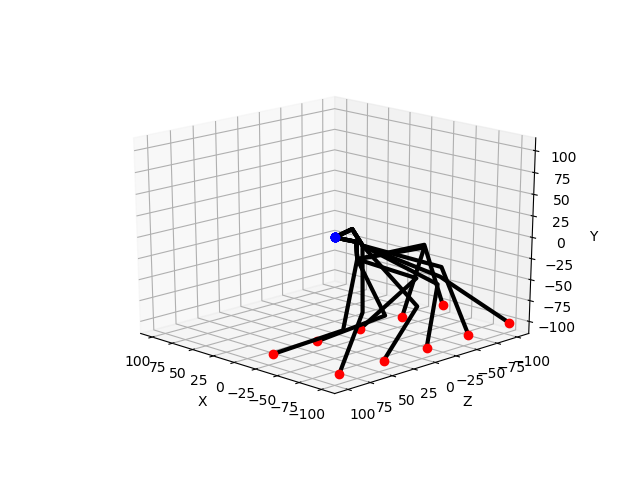

OK


In [311]:
%matplotlib notebook
setupView(110).view_init(elev=20., azim=135)

for z in range(-100,150,50):
    drawLegPoints(calcLegPoints(legIK(x+25,y,z)))
    drawLegPoints(calcLegPoints(legIK(x-50,y,z)))
    
print("OK")

## Forward Kinematics of the Body

To be able to calculate a Leg's Pose, we need to know where it starts when the Body has a specific Pose.
The Pose is defined by omega,phi and psi - the rotation angles - and xm,ym and zm - the Center of the Body.

<IPython.core.display.Javascript object>


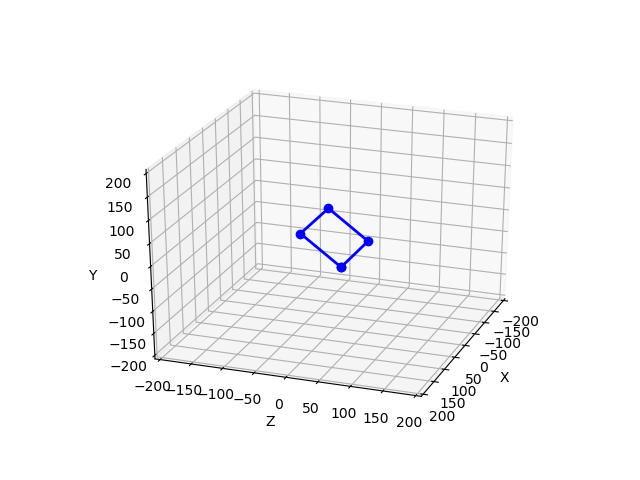

OK


In [312]:
%matplotlib notebook

L = 120
W = 90

def bodyIK(omega,phi,psi,xm,ym,zm):

    """
    Calculate the four Transformation-Matrices for our Legs
    Rx=X-Axis Rotation Matrix
    Ry=Y-Axis Rotation Matrix
    Rz=Z-Axis Rotation Matrix
    Rxyz=All Axis Rotation Matrix
    T=Translation Matrix
    Tm=Transformation Matrix
    Trb,Trf,Tlb,Tlf=final Matrix for RightBack,RightFront,LeftBack and LeftFront
    """
    
    Rx = np.array([
        [1, 0, 0, 0], 
        [0, np.cos(omega), -np.sin(omega), 0],
        [0,np.sin(omega),np.cos(omega),0],
        [0,0,0,1]])

    Ry = np.array([
        [np.cos(phi),0, np.sin(phi), 0], 
        [0, 1, 0, 0],
        [-np.sin(phi),0, np.cos(phi),0],
        [0,0,0,1]])

    Rz = np.array([
        [np.cos(psi),-np.sin(psi), 0,0], 
        [np.sin(psi),np.cos(psi),0,0],
        [0,0,1,0],
        [0,0,0,1]])

    Rxyz=Rx@Ry@Rz

    T = np.array([[0,0,0,xm],[0,0,0,ym],[0,0,0,zm],[0,0,0,0]])
    Tm = T+Rxyz
    
    Trb = Tm @ np.array([
        [np.cos(pi/2),0,np.sin(pi/2),-L/2],
        [0,1,0,0],
        [-np.sin(pi/2),0,np.cos(pi/2),-W/2],
        [0,0,0,1]])

    Trf = Tm @ np.array([
        [np.cos(pi/2),0,np.sin(pi/2),L/2],
        [0,1,0,0],
        [-np.sin(pi/2),0,np.cos(pi/2),-W/2],
        [0,0,0,1]])

    Tlf = Tm @ np.array([
        [np.cos(pi/2),0,np.sin(pi/2),L/2],
        [0,1,0,0],
        [-np.sin(pi/2),0,np.cos(pi/2),W/2],
        [0,0,0,1]])

    Tlb = Tm @ np.array([
        [np.cos(pi/2),0,np.sin(pi/2),-L/2],
        [0,1,0,0],
        [-np.sin(pi/2),0,np.cos(pi/2),W/2],
        [0,0,0,1]])
    
    return (Tlf,Trf,Tlb,Trb,Tm)

omega =  pi/4 # Body xrot
phi =0#math.pi/4# Body YRot
psi = 0#math.pi/6 # Body ZRot

xm = 0
ym = 0
zm = 0

(Tlf,Trf,Tlb,Trb,Tm)=bodyIK(omega,phi,psi,xm,ym,zm)

FP=[0,0,0,1]

CP=[x@FP for x in [Tlf,Trf,Tlb,Trb]]

setupView(200).view_init(elev=27., azim=20)
plt.plot([CP[0][0],CP[1][0],CP[3][0], CP[2][0],CP[0][0]],
         [CP[0][2],CP[1][2],CP[3][2], CP[2][2],CP[0][2]],
         [CP[0][1],CP[1][1],CP[3][1], CP[2][1],CP[0][1]], 'bo-', lw=2)

print("OK")

## complete the Kinematics-Model

Now we need to combine the Body's Kinematics with the four Legs. 
Input will be the Body-Pose (omega,phi,psi,xm,ym,zm) and Positions for all four Legs in World-Space (Lp).

Conversion from World to Leg-Space is still missing.

<IPython.core.display.Javascript object>


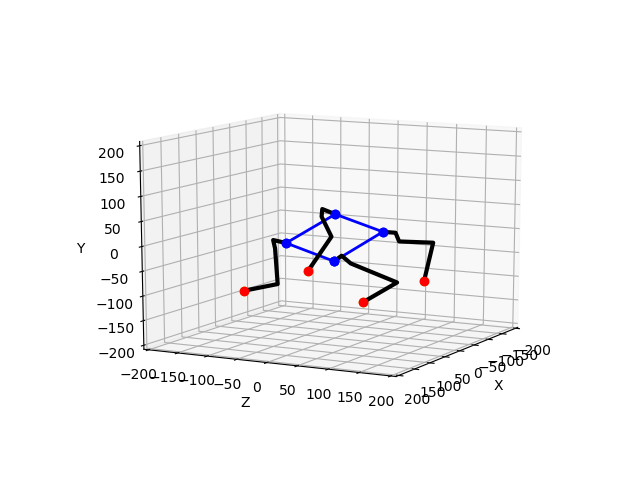

OK


In [313]:
%matplotlib notebook
setupView(200).view_init(elev=12., azim=28)

Lp=np.array([[100,-100,100,1],[100,-100,-100,1],[-100,-100,100,1],[-100,-100,-100,1]])


def drawRobot(Lp,bodyIk):

    (Tlf,Trf,Tlb,Trb,Tm)=bodyIk

    FP=[0,0,0,1]
    CP=[x@FP for x in [Tlf,Trf,Tlb,Trb]]

    [plt.plot([x[0]],[x[2]],[x[1]],'yo-') for x in Lp]

    plt.plot([CP[0][0],CP[1][0],CP[3][0],CP[2][0],CP[0][0]],
             [CP[0][2],CP[1][2],CP[3][2],CP[2][2],CP[0][2]],
             [CP[0][1],CP[1][1],CP[3][1],CP[2][1],CP[0][1]], 'bo-', lw=2)

    # Invert local X
    Ix=np.array([[-1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

    #Q=np.linalg.inv(Tlf)@(Lp[0])
    Q=np.linalg.inv(Tlf)@Lp[0]
    p=[Tlf@x for x in calcLegPoints(legIK(Q[0],Q[1],Q[2]))]
    drawLegPoints(p)

    Q=np.linalg.inv(Tlb)@Lp[2]
    p=[Tlb@x for x in calcLegPoints(legIK(Q[0],Q[1],Q[2]))]
    drawLegPoints(p)

    #TP=np.array([40,-150,0,1])

    Q=Ix@np.linalg.inv(Trf)@Lp[1]
    p=[Trf@Ix@x for x in calcLegPoints(legIK(Q[0],Q[1],Q[2]))]
    drawLegPoints(p)

    Q=Ix@np.linalg.inv(Trb)@Lp[3]
    p=[Trb@Ix@x for x in calcLegPoints(legIK(Q[0],Q[1],Q[2]))]
    drawLegPoints(p)

drawRobot(Lp,bodyIK(0.3,0.1,-0.4,xm,ym,zm))
    
print("OK")

## Verifying the Results

We can now apply some random poses on the Robot's Body to verify the correctness of all Legs.

<IPython.core.display.Javascript object>


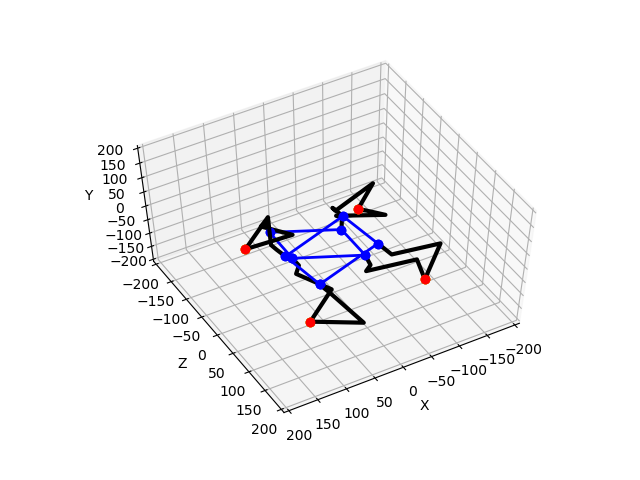

In [321]:
%matplotlib notebook
setupView(200).view_init(elev=12., azim=28)

drawRobot(Lp,bodyIK(-0.3,0.1,0.4,30,ym,zm))
drawRobot(Lp,bodyIK(-0.1,-0.1,-0.4,0,-60,-10))

## Finish

We are dont now with the Kinematics. We could now improve the code and make it shiny.